In [105]:
import pandas as pd
from dateutil import parser
from datetime import datetime, timedelta, date
import requests
from urllib import parse
import matplotlib.pyplot as plt
from prophet import Prophet
import seaborn as sns
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_cross_validation_metric
import numpy as np
import holidays
from prophet.make_holidays import make_holidays_df
import holidays


In [2]:
# National Energy System Operator (NESO)
# https://www.neso.energy/data-portal/historic-demand-data/historic_demand_data_2025
# All the electricity-related columns are in megawatts (MW).

In [3]:
'''
Historic electricity demand, interconnector, wind and solar outturn data for 2025. Please find a brief summary of some of the columns in the dataset:

“Demand” here is how much generation is required to meet all the electrical load (consumers + losses + station load + exports) that the transmission system sees or that is required.

ND = National Demand is the sum of metered generation, but excludes generation required to meet station load, hydro storage pumping and interconnector exports

TSD = Transmission System Demand is equal to the ND plus the additional generation required to meet station load, pump storage pumping and interconnector exports

“England and Wales Demand, as ND above but on an England and Wales basis.”


Further: “The sum of all the National Grid half‑hourly data is called the total Transmission System Demand (TSD) – this includes all demand met by the transmission system, including exports, pumping and power station demand.”

Because some embedded generation (wind & solar connected at distribution level) is invisible to the transmission metering, the dataset provides estimates of “embedded generation” to help make sense of the “demand” seen by the transmission system.

EMBEDDED_WIND_GENERATION
Estimate of wind generation from wind farms embedded in the distribution network (i.e. not on the transmission metering).
This generation reduces what the transmission system has to supply (because some load is offset by embedded generation). In effect, high embedded wind generation → lower demand from the transmission side.

IFA_FLOW, IFA2_FLOW, BRITNED_FLOW, MOYLE_FLOW, EAST_WEST_FLOW, NEMO_FLOW, NSL_FLOW, ELECLINK_FLOW, VIKING_FLOW, GREENLINK_FLOW
These are flows on specific interconnectors between GBR and other countries/regions. Negative means export from GB, positive means import into GB.

'''

'\nHistoric electricity demand, interconnector, wind and solar outturn data for 2025. Please find a brief summary of some of the columns in the dataset:\n\n“Demand” here is how much generation is required to meet all the electrical load (consumers + losses + station load + exports) that the transmission system sees or that is required.\n\nND = National Demand is the sum of metered generation, but excludes generation required to meet station load, hydro storage pumping and interconnector exports\n\nTSD = Transmission System Demand is equal to the ND plus the additional generation required to meet station load, pump storage pumping and interconnector exports\n\n“England and Wales Demand, as ND above but on an England and Wales basis.”\n\n\nFurther: “The sum of all the National Grid half‑hourly data is called the total Transmission System Demand (TSD) – this includes all demand met by the transmission system, including exports, pumping and power station demand.”\n\nBecause some embedded g

In [4]:
# TSD ≈ ND + Station_Load + Pumped_Storage + Interconnector_Exports − Embedded_Generation

In [6]:
combined_df = pd.read_csv("demanddata_2014_2025_combined.csv")

In [7]:
df = combined_df.copy()

In [ ]:
# df = pd.read_csv("demanddata_2025.csv")

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207408 entries, 0 to 207407
Data columns (total 23 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   SETTLEMENT_DATE            207408 non-null  object 
 1   SETTLEMENT_PERIOD          207408 non-null  int64  
 2   ND                         207408 non-null  int64  
 3   TSD                        207408 non-null  int64  
 4   ENGLAND_WALES_DEMAND       207408 non-null  int64  
 5   EMBEDDED_WIND_GENERATION   207408 non-null  int64  
 6   EMBEDDED_WIND_CAPACITY     207408 non-null  int64  
 7   EMBEDDED_SOLAR_GENERATION  207408 non-null  int64  
 8   EMBEDDED_SOLAR_CAPACITY    207408 non-null  int64  
 9   NON_BM_STOR                207408 non-null  int64  
 10  PUMP_STORAGE_PUMPING       207408 non-null  int64  
 11  IFA_FLOW                   207408 non-null  int64  
 12  IFA2_FLOW                  207408 non-null  int64  
 13  BRITNED_FLOW               20

In [9]:
pd.set_option('display.max_columns', None)

In [10]:
df = df[['SETTLEMENT_DATE', 'SETTLEMENT_PERIOD', 'ND', 'TSD',
       'ENGLAND_WALES_DEMAND', 'EMBEDDED_WIND_GENERATION',
       'EMBEDDED_WIND_CAPACITY', 'EMBEDDED_SOLAR_GENERATION',
       'EMBEDDED_SOLAR_CAPACITY', 'NON_BM_STOR', 'PUMP_STORAGE_PUMPING',
       'SCOTTISH_TRANSFER', 'IFA_FLOW', 'IFA2_FLOW', 'BRITNED_FLOW',
       'MOYLE_FLOW', 'EAST_WEST_FLOW', 'NEMO_FLOW', 'NSL_FLOW',
       'ELECLINK_FLOW', 'VIKING_FLOW', 'GREENLINK_FLOW']]   # to keep the original column structure

In [11]:
df.head()

,SETTLEMENT_DATE,SETTLEMENT_PERIOD,ND,TSD,ENGLAND_WALES_DEMAND,EMBEDDED_WIND_GENERATION,EMBEDDED_WIND_CAPACITY,EMBEDDED_SOLAR_GENERATION,EMBEDDED_SOLAR_CAPACITY,NON_BM_STOR,PUMP_STORAGE_PUMPING,SCOTTISH_TRANSFER,IFA_FLOW,IFA2_FLOW,BRITNED_FLOW,MOYLE_FLOW,EAST_WEST_FLOW,NEMO_FLOW,NSL_FLOW,ELECLINK_FLOW,VIKING_FLOW,GREENLINK_FLOW
0,01-JAN-2014,1,30008,31920,27048,1084,2434,0,3349,0,870,NaN,1990,0,1000,-157,-285,0,NaN,NaN,NaN,NaN
1,01-JAN-2014,2,30589,32491,27625,1079,2434,0,3349,0,860,NaN,1990,0,1000,-157,-285,0,NaN,NaN,NaN,NaN
2,01-JAN-2014,3,30306,32521,27361,1079,2434,0,3349,0,1173,NaN,1990,0,1000,-157,-285,0,NaN,NaN,NaN,NaN
3,01-JAN-2014,4,29280,31735,26447,931,2434,0,3349,0,1413,NaN,1992,0,1000,-157,-285,0,NaN,NaN,NaN,NaN
4,01-JAN-2014,5,28174,30661,25461,931,2434,0,3349,0,1417,NaN,1748,0,880,-157,-313,0,NaN,NaN,NaN,NaN


In [12]:
df.tail(2)

,SETTLEMENT_DATE,SETTLEMENT_PERIOD,ND,TSD,ENGLAND_WALES_DEMAND,EMBEDDED_WIND_GENERATION,EMBEDDED_WIND_CAPACITY,EMBEDDED_SOLAR_GENERATION,EMBEDDED_SOLAR_CAPACITY,NON_BM_STOR,PUMP_STORAGE_PUMPING,SCOTTISH_TRANSFER,IFA_FLOW,IFA2_FLOW,BRITNED_FLOW,MOYLE_FLOW,EAST_WEST_FLOW,NEMO_FLOW,NSL_FLOW,ELECLINK_FLOW,VIKING_FLOW,GREENLINK_FLOW
207406,30-OCT-2025,47,22596,26714,21485,5433,6606,0,20993,0,-985,5818.0,654,-1,-1040,171,0,-1011,-1003.0,88.0,-1448.0,350.0
207407,30-OCT-2025,48,21901,26024,20840,5373,6606,0,20993,0,-1068,5760.0,703,-1,-1038,32,0,-1022,-1081.0,67.0,-1449.0,350.0


In [13]:
df.columns

Index(['SETTLEMENT_DATE', 'SETTLEMENT_PERIOD', 'ND', 'TSD',
       'ENGLAND_WALES_DEMAND', 'EMBEDDED_WIND_GENERATION',
       'EMBEDDED_WIND_CAPACITY', 'EMBEDDED_SOLAR_GENERATION',
       'EMBEDDED_SOLAR_CAPACITY', 'NON_BM_STOR', 'PUMP_STORAGE_PUMPING',
       'SCOTTISH_TRANSFER', 'IFA_FLOW', 'IFA2_FLOW', 'BRITNED_FLOW',
       'MOYLE_FLOW', 'EAST_WEST_FLOW', 'NEMO_FLOW', 'NSL_FLOW',
       'ELECLINK_FLOW', 'VIKING_FLOW', 'GREENLINK_FLOW'],
      dtype='object')

In [14]:
df['SETTLEMENT_PERIOD'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50])

In [ ]:
# df[df['SETTLEMENT_PERIOD'].isin([49, 50])] # daylight savings

In [15]:
df['SETTLEMENT_DATE'].unique()

array(['01-JAN-2014', '02-JAN-2014', '03-JAN-2014', ..., '28-OCT-2025',
       '29-OCT-2025', '30-OCT-2025'], dtype=object)

In [ ]:
# Date format codes for datetime.strptime / pd.to_datetime:
# %d = day of month (01-31)
# %b = abbreviated month name (Jan, Feb, …)
# %B = full month name (January, February, …)
# %m = month as number (01-12)
# %y = 2-digit year (00-99)
# %Y = 4-digit year (e.g., 2025)
# %H = hour (00-23, 24-hour clock)
# %I = hour (01-12, 12-hour clock)
# %p = AM/PM
# %M = minute (00-59)
# %S = second (00-59)
# %f = microsecond (000000-999999)
# %a = abbreviated weekday (Mon, Tue, …)
# %A = full weekday (Monday, Tuesday, …)
# %j = day of year (001-366)
# Example: datetime.strptime("30-AUG-2025", "%d-%b-%Y")


In [16]:
df['SETTLEMENT_DATE'] = pd.to_datetime(df['SETTLEMENT_DATE'], dayfirst=True, format="mixed")

In [20]:
# Example:
#   ND = 500 MW
#   Adjustments (pumping/station load/interconnectors) = 60 MW
#   Embedded wind + solar = 200 MW
#   Then TSD = 500 + 60 - 200 = 360 MW
# So ND can be greater than TSD when embedded generation is high or pumped storage is generating.

In [21]:
df[df['ND'] > df['TSD']]

,SETTLEMENT_DATE,SETTLEMENT_PERIOD,ND,TSD,ENGLAND_WALES_DEMAND,EMBEDDED_WIND_GENERATION,EMBEDDED_WIND_CAPACITY,EMBEDDED_SOLAR_GENERATION,EMBEDDED_SOLAR_CAPACITY,NON_BM_STOR,PUMP_STORAGE_PUMPING,SCOTTISH_TRANSFER,IFA_FLOW,IFA2_FLOW,BRITNED_FLOW,MOYLE_FLOW,EAST_WEST_FLOW,NEMO_FLOW,NSL_FLOW,ELECLINK_FLOW,VIKING_FLOW,GREENLINK_FLOW
47314,2016-09-12,37,35642,35619,32451,1740,4403,375,11433,535,12,NaN,1996,0,1016,0,0,0,NaN,NaN,NaN,NaN
47315,2016-09-12,38,35720,35709,32525,1621,4403,171,11433,525,14,NaN,1996,0,1011,0,0,0,NaN,NaN,NaN,NaN
47988,2016-09-26,39,39255,39251,35273,903,4649,0,11433,512,9,NaN,994,0,983,234,0,0,NaN,NaN,NaN,NaN
61990,2017-07-15,25,27200,27189,24579,1994,5305,2490,12372,519,8,NaN,1999,0,948,114,320,0,NaN,NaN,NaN,NaN
62038,2017-07-16,25,26590,26573,24220,1585,5305,3720,12372,529,12,NaN,1704,0,874,145,69,0,NaN,NaN,NaN,NaN
77156,2018-05-27,23,23334,23303,20485,2158,5859,6300,13052,556,10,NaN,1121,0,405,-14,464,0,NaN,NaN,NaN,NaN
77845,2018-06-10,40,28841,28829,25632,500,5859,829,13052,521,9,NaN,1997,0,1001,92,386,0,NaN,NaN,NaN,NaN
77846,2018-06-10,41,28672,28535,25343,467,5859,406,13052,644,7,NaN,1996,0,1000,157,382,0,NaN,NaN,NaN,NaN
77847,2018-06-10,42,28495,28360,25209,434,5859,110,13052,639,4,NaN,1996,0,1000,213,363,0,NaN,NaN,NaN,NaN
77848,2018-06-10,43,28324,28208,25100,420,5859,9,13052,620,4,NaN,1996,0,976,223,334,0,NaN,NaN,NaN,NaN


In [ ]:
# invistigate further

In [17]:
df.groupby(by = ['SETTLEMENT_DATE']).sum().reset_index().drop(columns = ['SETTLEMENT_PERIOD'])

,SETTLEMENT_DATE,ND,TSD,ENGLAND_WALES_DEMAND,EMBEDDED_WIND_GENERATION,EMBEDDED_WIND_CAPACITY,EMBEDDED_SOLAR_GENERATION,EMBEDDED_SOLAR_CAPACITY,NON_BM_STOR,PUMP_STORAGE_PUMPING,SCOTTISH_TRANSFER,IFA_FLOW,IFA2_FLOW,BRITNED_FLOW,MOYLE_FLOW,EAST_WEST_FLOW,NEMO_FLOW,NSL_FLOW,ELECLINK_FLOW,VIKING_FLOW,GREENLINK_FLOW
0,2014-01-01,1514419,1591769,1373378,61037,116832,994,160752,487,22079,0.0,92056,0,44864,-10178,-16731,0,0.0,0.0,0.0,0.0
1,2014-01-02,1722972,1793335,1579494,52227,116832,10388,160896,612,18871,0.0,93030,0,39935,-8824,-12983,0,0.0,0.0,0.0,0.0
2,2014-01-03,1756703,1828833,1606954,78808,116832,6188,161088,1429,23095,0.0,92715,0,44578,-8954,-9250,0,0.0,0.0,0.0,0.0
3,2014-01-04,1709434,1783278,1549245,33724,116832,1754,161232,1807,21744,0.0,93296,0,46858,-9239,-15634,0,0.0,0.0,0.0,0.0
4,2014-01-05,1678218,1747526,1523299,49495,116832,3319,161424,1185,22831,0.0,93640,0,47073,-9256,-6678,0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4316,2025-10-26,1257410,1321160,1156434,179854,330300,49688,1049650,0,-27768,192244.0,39550,31218,32040,-7745,-13460,33349,11744.0,34676.0,24404.0,-10700.0
4317,2025-10-27,1311483,1391706,1195398,149219,317088,76378,1007664,0,-14978,132546.0,51570,-870,11855,-3452,-8644,32392,33616.0,37591.0,22978.0,3856.0
4318,2025-10-28,1283036,1368731,1188126,181534,317088,73758,1007664,0,-18302,219528.0,50372,-48,6363,-10291,-8220,26261,35564.0,32192.0,-3454.0,-10982.0
4319,2025-10-29,1409860,1494291,1292516,90637,317088,33363,1007664,0,-11650,145679.0,45574,-48,-6087,-9183,-7822,14521,56359.0,41769.0,18835.0,-18808.0


In [22]:
gdf = df.groupby(by = ['SETTLEMENT_DATE']).sum().reset_index().drop(columns = ['SETTLEMENT_PERIOD'])

In [23]:
print("Start Date : {} , End Date : {}".format(gdf['SETTLEMENT_DATE'].unique()[0], gdf['SETTLEMENT_DATE'].unique()[-1]))

Start Date : 2014-01-01 00:00:00 , End Date : 2025-10-30 00:00:00


In [24]:
df2 = gdf[['SETTLEMENT_DATE', 'ND', 'TSD']]

In [25]:
df2

,SETTLEMENT_DATE,ND,TSD
0,2014-01-01,1514419,1591769
1,2014-01-02,1722972,1793335
2,2014-01-03,1756703,1828833
3,2014-01-04,1709434,1783278
4,2014-01-05,1678218,1747526
...,...,...,...
4316,2025-10-26,1257410,1321160
4317,2025-10-27,1311483,1391706
4318,2025-10-28,1283036,1368731
4319,2025-10-29,1409860,1494291


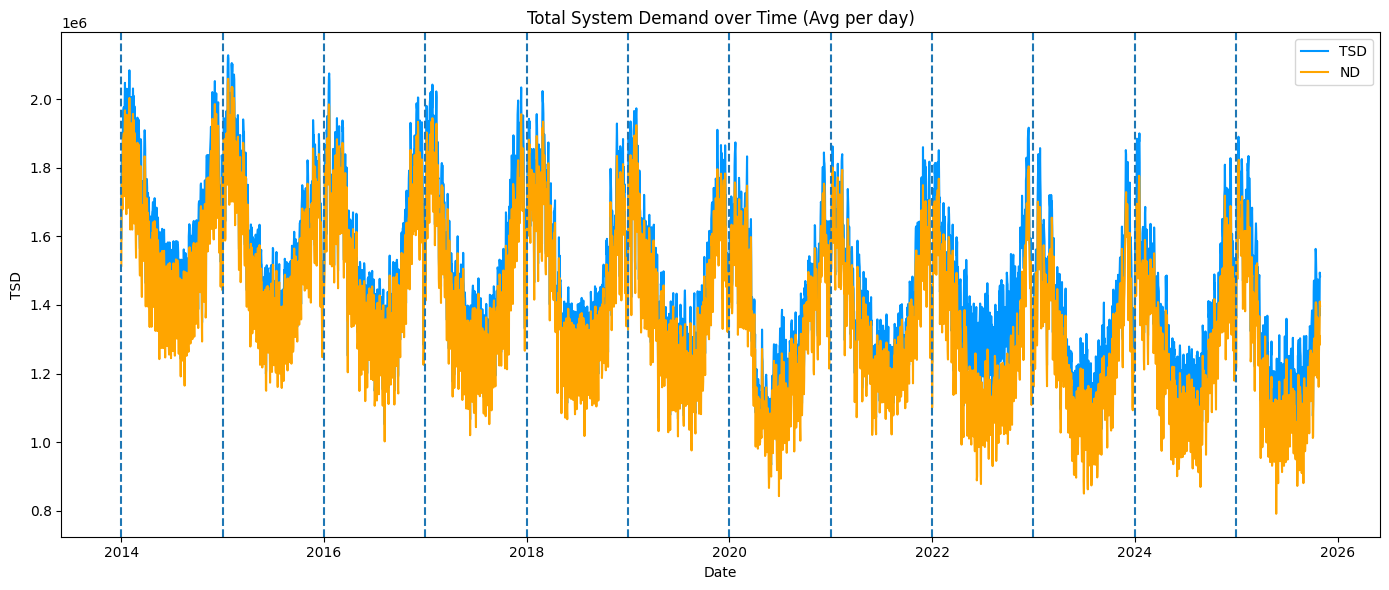

In [39]:
# Plot
plt.figure(figsize=(14, 6))
plt.plot(df2["SETTLEMENT_DATE"], df2["TSD"], color='#0096FF', label='TSD')
plt.plot(df2["SETTLEMENT_DATE"], df2["ND"], color='orange', label='ND')
plt.legend()

# Add a dashed vertical line at January 1st each year
years = range(2014, 2026)
for y in years:
    plt.axvline(pd.Timestamp(f"{y}-01-01"), linestyle="--")

plt.title("Total System Demand over Time (Avg per day)")
plt.xlabel("Date")
plt.ylabel("TSD")
plt.tight_layout()
plt.show()


Prophet Model


In [40]:
pdf = df2[["SETTLEMENT_DATE", "TSD"]].copy()
pdf.rename(columns={"SETTLEMENT_DATE": "ds", "TSD": "y"}, inplace=True)

In [41]:
pdf.head(3)

,ds,y
0,2014-01-01,1591769
1,2014-01-02,1793335
2,2014-01-03,1828833


In [44]:
# ptrain = pdf[pdf['ds'] < '2024-01-01']

In [106]:
# holidays
uk_holidays = pd.DataFrame(list(holidays.UK(years=range(2014,2026)).items()), columns=['ds','holiday'])
# Optional: add extra windows if demand is affected before/after holiday
# holidays_df['lower_window'] = -1
# holidays_df['upper_window'] = 1  # includes next day effect

In [146]:
from prophet import Prophet

model = Prophet(
    # changepoint_prior_scale = 0.2,       # default 0.05, try 0.001-0.5
    # seasonality_prior_scale = 15,         # default 10, try 1-50
    # holidays_prior_scale = 10,            # default 10, try 1-50
    # interval_width = 0.70,                  # setting the confidence interval
    yearly_seasonality = True, weekly_seasonality = True, daily_seasonality = False)
model.add_country_holidays(country_name='UK')
model.fit(pdf)

In [ ]:
# Prophet's Cross-Validation is an implementation of the rolling forecasting concept.

# The data that gets added to the training set for the next iteration is the actual, true historical data that occurred during the period of time that just passed.

In [147]:
# Prophet cross-validation
# Simulate rolling one-day-ahead forecasts for 2024
df_cv = cross_validation(
    model,
    horizon='7 days',
    period='1 days',
    initial= '4200 days' #appx 10+ years
)

INFO:prophet:Making 114 forecasts with cutoffs between 2025-07-02 00:00:00 and 2025-10-23 00:00:00


  0%|          | 0/114 [00:00<?, ?it/s]

In [148]:
# Compute performance metrics
df_perf = performance_metrics(df_cv)
print(df_perf.head())

# Compute MAPE manually
def mape(actual, pred):
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

my_mape = mape(df_cv['y'], df_cv['yhat'])
print("MAPE:", my_mape)


  horizon           mse          rmse           mae      mape     mdape  \
0  1 days  4.025494e+09  63446.777055  49726.684019  0.040577  0.033823   
1  2 days  3.991673e+09  63179.688989  49464.540417  0.040292  0.034817   
2  3 days  3.932454e+09  62709.279470  49141.381416  0.039914  0.034766   
3  4 days  3.952572e+09  62869.484181  49305.221669  0.039940  0.034819   
4  5 days  4.067045e+09  63773.383991  49926.303955  0.040293  0.035083   

      smape  coverage  
0  0.040421  0.903509  
1  0.040163  0.912281  
2  0.039831  0.921053  
3  0.039833  0.929825  
4  0.040139  0.903509  
MAPE: 4.003541869936048


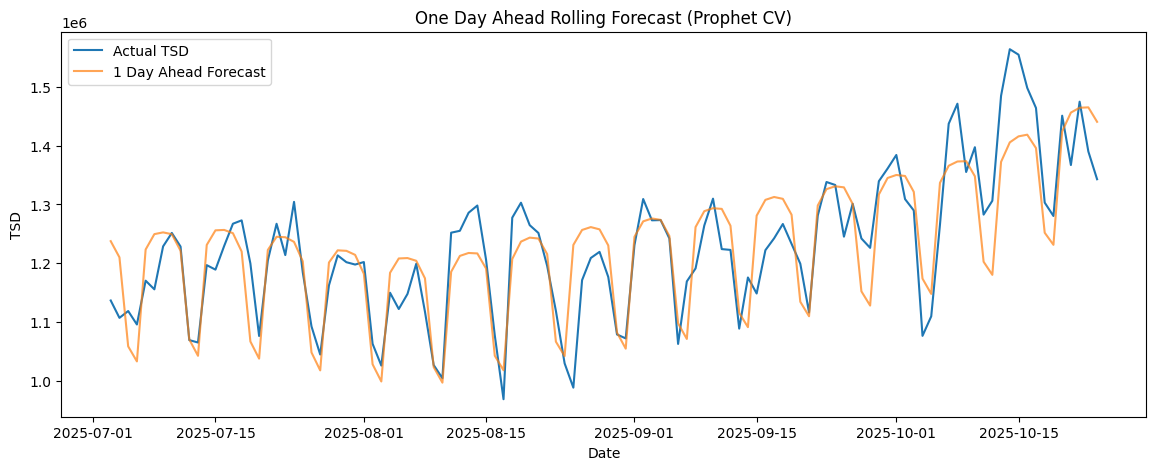

In [149]:
df_cv['horizon'] = df_cv['ds'] - df_cv['cutoff']
df_1d = df_cv[df_cv['horizon'] == pd.Timedelta(days=1)]
plt.figure(figsize=(14,5))
plt.plot(df_1d['ds'], df_1d['y'], label='Actual TSD')
plt.plot(df_1d['ds'], df_1d['yhat'], label='1 Day Ahead Forecast', alpha=0.7)
plt.xlabel('Date')
plt.ylabel('TSD')
plt.title('One Day Ahead Rolling Forecast (Prophet CV)')
plt.legend()
plt.show()


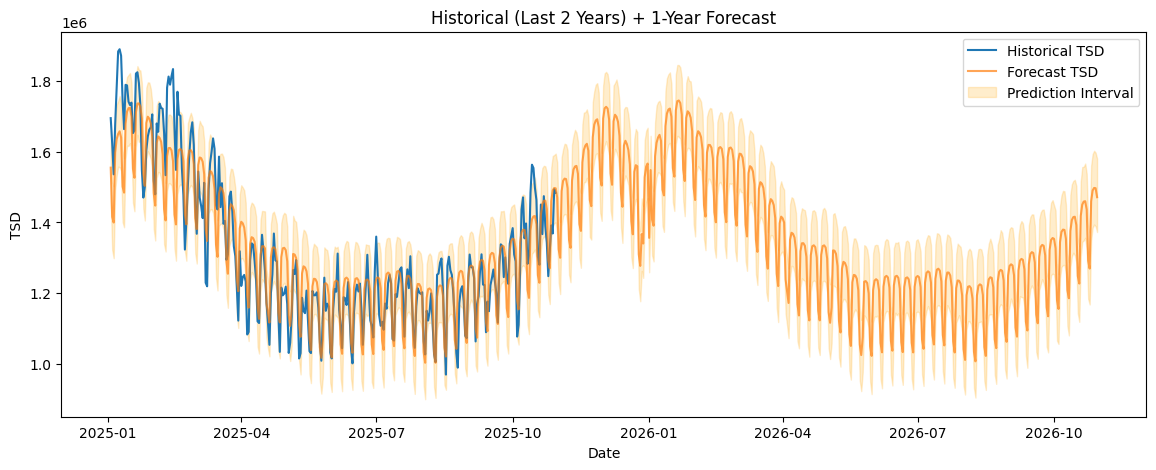

In [157]:
# Extrapolate 1 year beyond last date
future = model.make_future_dataframe(periods=365, freq='D')
forecast = model.predict(future)

# Filter for plotting: last 2 years of historical + forecast
last_2_years = pdf['ds'].max() - pd.Timedelta(days=300)
plot_start_date = last_2_years

mask_hist = pdf['ds'] >= plot_start_date
mask_forecast = forecast['ds'] >= plot_start_date

plt.figure(figsize=(14,5))
plt.plot(pdf.loc[mask_hist, 'ds'], pdf.loc[mask_hist, 'y'], label='Historical TSD')
plt.plot(forecast.loc[mask_forecast, 'ds'], forecast.loc[mask_forecast, 'yhat'], label='Forecast TSD', alpha=0.7)
plt.fill_between(forecast.loc[mask_forecast, 'ds'],
                 forecast.loc[mask_forecast, 'yhat_lower'],
                 forecast.loc[mask_forecast, 'yhat_upper'],
                 color='orange', alpha=0.2, label='Prediction Interval')
plt.xlabel('Date')
plt.ylabel('TSD')
plt.title('Historical (Last 2 Years) + 1-Year Forecast')
plt.legend()
plt.show()